In [1]:
import yfinance as yf
from transformers import pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Yeni İşlevler oluşturma:

* İşlev get_stock_data  
* İşlev plot_stock_trend  
* İşlev plot_daily_returns
* İşlev plot_cumulative_returns 
* İşlev - insights_stock_trend
* İşlev - cal_returns

_Not: Kodun erişilebilirliği için yeni işlevler oluşturuldu, işlevleri kullanarak birden fazla ticker üzerinde analiz yapabilirsiniz._


In [2]:
# İşlev - cal_returns
def calc_returns(prices):  
    # Getirileri saklamak için boş bir liste başlatma
    returns = []  
    for i in range(1, len(prices)):
        # Getiri oranını hesaplama ve listeye ekleme - 'returns'
        r = (prices[i] / prices[i-1]) - 1
        r_rounded = round(r, 2)  # Getiriyi 2 ondalık basamağa yuvarlamak için round fonksiyonunu kullanma
        returns.append(r_rounded)
    return returns

In [3]:
def get_stock_data(ticker_symbol, start_date, end_date):
    """
    Bu işlev, verilen bir ticker sembolü için başlangıç ve bitiş tarihleri arasında tarihi hisse verilerini getirir. 
    Hisse verilerini almak için ytfinance kütüphanesini kullanır.
    
    Argümanlar:
    - ticker_symbol (str): Hissenin ticker sembolü.
    - start_date (str): Başlangıç tarihi, 'YYYY-MM-DD' formatında.
    - end_date (str): Bitiş tarihi, 'YYYY-MM-DD' formatında.
    
    Döndürür:
    - pandas.DataFrame: Açılış, kapanış, yüksek, düşük, hacim dahil hisse verileri.
    """
    # Verilen hisse ticker sembolü için bir Ticker nesnesi oluşturmak için yfinance kütüphanesini kullanma
    ticker_data = yf.Ticker(ticker_symbol)
    # Ticker nesnesinin History metodunu kullanarak tarihi hisse verilerini alma
    stock_data = ticker_data.history(start=start_date, end=end_date)
    return stock_data

def plot_stock_trend(dates, closing_prices):
    """
    Bu işlev, verilen tarihler için hisse kapanış fiyatlarının trendini çizer. 
    Bu, hisse fiyatının verilen zaman diliminde nasıl hareket ettiğini gösterir.
    
    Argümanlar:
    - dates (pandas.DatetimeIndex): Kapanış fiyatlarına karşılık gelen tarihler.
    - closing_prices (list): Hissenin kapanış fiyatlarının listesi.
    """
    plt.figure(figsize=(12, 6))
    # Kapanış fiyatlarını tarihlere karşı çizme
    #'marker' - her veri noktasını bir daire ile işaretleme
    #'linestyle' - çizgi stili düz bir çizgi
    #'color' - hem çizgi hem de işaretleyicinin rengi - çelik mavisi
    plt.plot(dates, closing_prices, marker='o', linestyle='-', color='steelblue')
    plt.title('Hisse Fiyatı Trendi')
    plt.xlabel('Tarih')
    plt.ylabel('Kapanış Fiyatı (₺)')
    # X eksenindeki etiketleri daha iyi okunabilirlik için döndürme
    plt.xticks(rotation=45)
    # Verilerin daha iyi anlaşılması için ızgara çizgilerini etkinleştirme
    plt.grid(True)
    plt.show()

def plot_daily_returns(dates, daily_returns):
    """
    Bu işlev, verilen bir zaman diliminde hisse senedinin günlük getirilerini çizer. 
    Günlük getiriler, bir günün kapanış fiyatından diğerine yüzde değişim olarak hesaplanır.
    
    Argümanlar:
    - dates (pandas.DatetimeIndex): Günlük getirilerle ilişkili tarihler.
    - daily_returns (list): Hisse fiyatlarından hesaplanan günlük getirilerin listesi.
    """
    plt.figure(figsize=(12, 6))
    # İlk tarihi atlayarak çizme çünkü günlük getiriler ikinci gün (ilk gün için getiri yok) başlamaktadır
    plt.plot(dates[1:], daily_returns, marker='o', linestyle='-', color='red')
    plt.title('Günlük Getiriler Trendi')
    plt.xlabel('Tarih')
    plt.ylabel('Günlük Getiri')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

def plot_cumulative_returns(dates, stock_returns):
    """
    Bu işlev, verilen bir zaman diliminde hisse senedinin kümülatif getirilerini çizer. 
    Kümülatif getiriler, zaman dilimindeki toplam getiriyi gösterir.
    Kümülatif getiriler, her tarihe kadar tüm günlük getirilerin toplamı ile hesaplanır.
    
    Argümanlar:
    - dates (pandas.DatetimeIndex): Hisse getirileriyle ilişkili tarihler.
    - stock_returns (list): Kümülatif getirileri hesaplamak için kullanılacak hisse getirilerinin listesi.
    """
    # Her elemanın o tarihe kadar olan toplam getiri olduğu yeni bir liste oluşturma
    cumulative_returns = [sum(stock_returns[:i+1]) for i in range(len(stock_returns))]
    plt.figure(figsize=(12, 6))
    # İlk tarihi atlayarak çizme çünkü kümülatif getiriler ikinci gün itibariyle hesaplanır
    plt.plot(dates[1:], cumulative_returns, marker='o', linestyle='-', color='green')
    plt.title('Kümülatif Getiriler')
    plt.xlabel('Tarih')
    plt.ylabel('Kümülatif Getiri')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

def insights_stock_trend(closing_prices, stock_returns):
    """
    Bu işlev, verilen bir zaman diliminde hisse senedinin temel trendlerini otomatik olarak verir 
    (Fiyat değişim trendi, Günlük getirilerde tutarlılık ve Bir günde en büyük kazanç ve düşüşü belirleme).
    
    Argümanlar:
    - closing_prices (list): Kapanış hisse fiyatlarının listesi.
    - stock_returns (list): Hisse getirilerinin listesi.
    
    Döndürür:
    - str: Hissenin fiyat trendi, getiri tutarlılığı ve önemli günlük değişiklikler hakkında bilgiler.
    """
    
    # Insights değişkenini boş bir string olarak başlatma
    insights = "" 
    
    # Verilen dönem boyunca fiyat değişim trendi
    price_change_percentage = ((closing_prices[-1] - closing_prices[0]) / closing_prices[0]) * 100
    if price_change_percentage > 0:
        insights += f"Hisse fiyatı dönemde {price_change_percentage:.2f}% arttı.\n"
    elif price_change_percentage < 0:
        insights += f"Hisse fiyatı dönemde {price_change_percentage:.2f}% azaldı.\n"
    else:
        insights += "Hisse fiyatı dönemde değişmedi.\n"

    #Consistency trend in daily returns
    positive_days = sum(1 for r in stock_returns if r > 0)
    negative_days = sum(1 for r in stock_returns if r < 0)
    if all(r > 0 for r in stock_returns):
        insights += "Hisse senedi, dönemde her gün tutarlı bir pozitif getiri gösterdi.\n"
    elif all(r < 0 for r in stock_returns):
        insights += "Hisse senedi, dönemde her gün tutarlı bir negatif getiri gösterdi.\n"
    else:
        insights += f"Hisse getirileri değişkenlik gösterdi; dönemde {positive_days} pozitif getiri günü ve {negative_days} negatif getiri günü oldu.\n"
        
    # Bir günde en büyük kazanç ve düşüşü belirleme
    max_gain = max(stock_returns)
    max_drop = min(stock_returns)
    insights += f"En büyük tek günlük kazanç {max_gain:.2f}%, en büyük tek günlük düşüş ise {max_drop:.2f}% olarak belirlendi.\n"
    return insights

#### Seçilen Şirket - Bank of America Corporation (BAC)

In [4]:
# Belirlenen Parametreler (BAC ticker sembolü kullanılarak)
ticker_symbol = "BAC"
start_date = "2023-05-01"
end_date = "2023-05-14"

# Verilen ticker sembolü ve tarih aralığı için hisse verilerini alma
stock_data = get_stock_data(ticker_symbol, start_date, end_date)

In [5]:
stock_data.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-05-01 00:00:00-04:00,28.420492,28.459029,27.938788,27.977325,34076800,0.0,0.0
2023-05-02 00:00:00-04:00,27.794279,27.803913,26.695994,27.129528,70797700,0.0,0.0
2023-05-03 00:00:00-04:00,27.129529,27.457087,26.792336,26.840508,51139500,0.0,0.0
2023-05-04 00:00:00-04:00,26.570752,26.792335,25.848197,26.002342,82173800,0.0,0.0
2023-05-05 00:00:00-04:00,26.609289,26.869407,26.464776,26.695993,50050100,0.0,0.0


In [6]:
# Hisse verilerinden kapanış fiyatlarını alma
closing_prices = stock_data['Close'].tolist()

# Kapanış fiyatlarından günlük getirileri hesaplama
stock_returns = calc_returns(closing_prices)

#### Belirtilen süre içerisinde ilgili sonuçların yazdırılması

In [7]:
#Belirtilen periyottaki her gün için kapanış fiyatlarının yazdırılması
print("KClosing Prices (in $):")
for date, price in zip(stock_data.index, closing_prices): 
    print(f"{date.date()}: {price:.2f}")

#Belirtilen tarihler arasındaki her döneme ait günlük getiri yüzdelerinin yazdırılması
print("\nReturns:")
for i, return_value in enumerate(stock_returns):
    print(f"Period {i+1}: {return_value:.2%}")

#Kapanış fiyatları ve hisse senedi getirileri trendine dayalı temel bilgileri yazdırma
print("\nBasic Insights:")
print(insights_stock_trend(closing_prices, stock_returns))

KClosing Prices (in $):
2023-05-01: 27.98
2023-05-02: 27.13
2023-05-03: 26.84
2023-05-04: 26.00
2023-05-05: 26.70
2023-05-08: 26.68
2023-05-09: 26.65
2023-05-10: 26.32
2023-05-11: 26.39
2023-05-12: 26.10

Returns:
Period 1: -3.00%
Period 2: -1.00%
Period 3: -3.00%
Period 4: 3.00%
Period 5: -0.00%
Period 6: -0.00%
Period 7: -1.00%
Period 8: 0.00%
Period 9: -1.00%

Basic Insights:
Hisse fiyatı dönemde -6.71% azaldı.
Hisse getirileri değişkenlik gösterdi; dönemde 1 pozitif getiri günü ve 5 negatif getiri günü oldu.
En büyük tek günlük kazanç 0.03%, en büyük tek günlük düşüş ise -0.03% olarak belirlendi.



#### Sonuçların görsel temsili

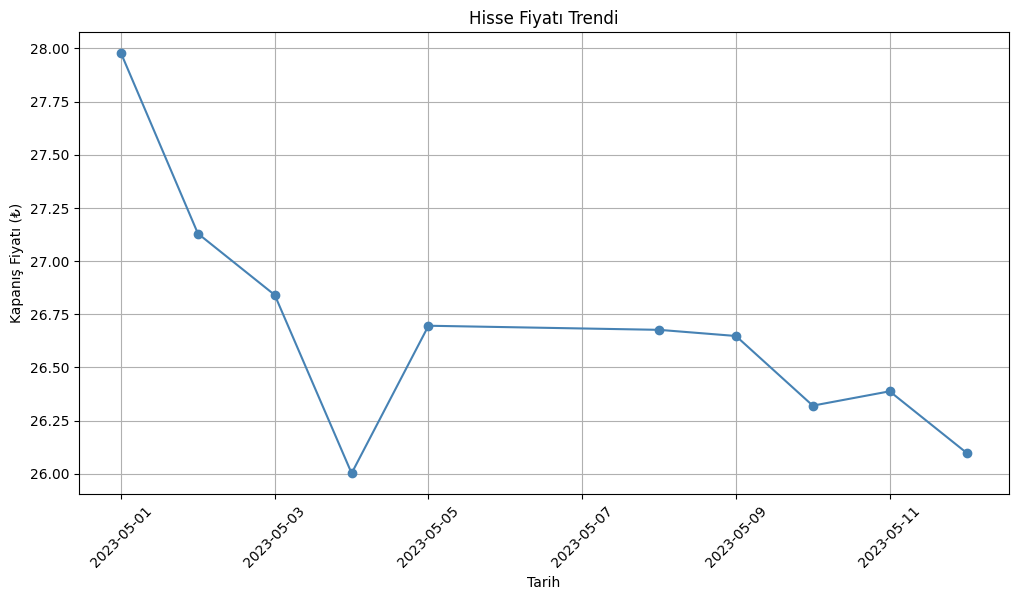

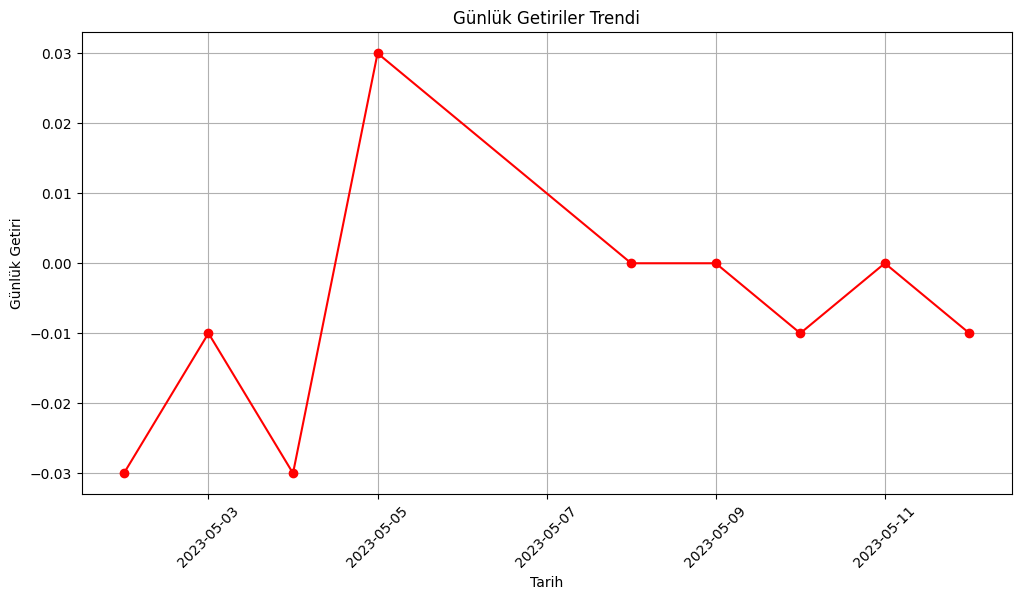

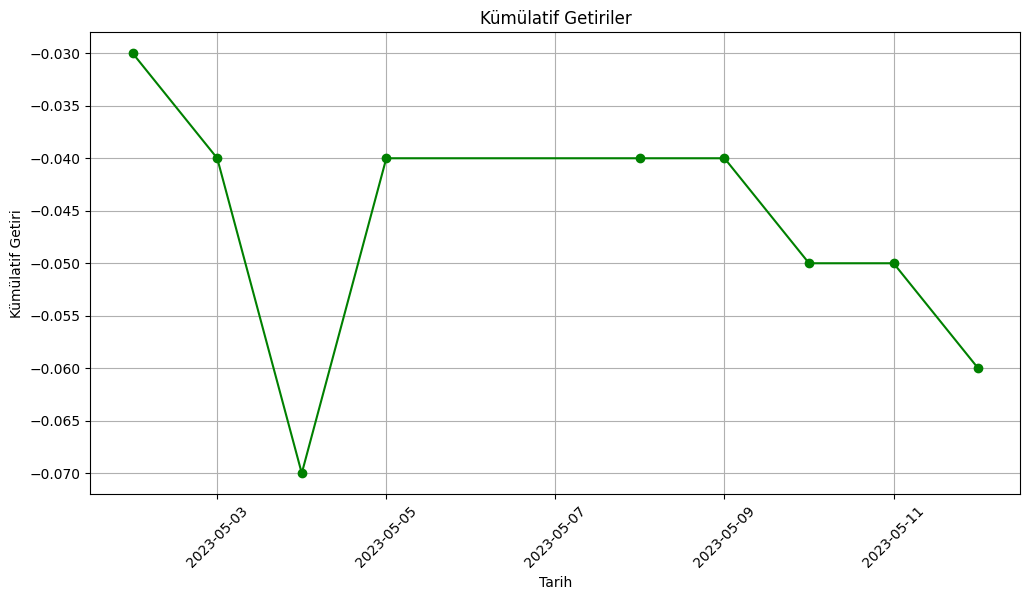

In [8]:
#Hisse senedi kapanış fiyatlarının zaman içindeki eğilimini çizmek
dates = stock_data.index
plot_stock_trend(dates, closing_prices)

#Belirli bir dönemdeki değişkenliklerini görmek için günlük getirilerin grafiğini çizme
plot_daily_returns(dates, stock_returns)

#Dönem içindeki toplam kazanç veya kayıp yüzdesini göstermek için kümülatif getirilerin grafiğini çizin
plot_cumulative_returns(dates, stock_returns)

#### Yukarıdan bilgiler:

* Hisse Senedi Fiyat Trendi: İlk grafik, söz konusu dönemde hisse senedinin kapanış fiyatlarında azalma eğilimi göstermektedir. Bu, söz konusu dönemde BAC için düşüş yönlü (düşen fiyat eğilimi) piyasanın göstergesi olabilir. Fiyatlarda bir düşüş var ancak kademeli olarak düşmeden önce biraz artması bir miktar dalgalanmaya işaret edebilir. 
* Günlük Getiri Trendi: Günlük getirileri gösteren ikinci grafik, verilen zaman diliminde sıfırın üstünde ve altında dalgalanmaktadır. Hisse senedi farklı günlerde pozitif ve negatif getiriler elde etti, tıpkı borsa davranışı gibi. İkinci gündeki yükseliş (günlük getiri %3'ün üzerindeydi) ve ardından düşüş (getiri %-3 civarında) yine yüksek seviyede volatiliteyi gösteriyor. 
* Kümülatif Getiriler: Üçüncü grafik, hisse senedinin dönem içindeki performansının toplu bir ölçüsünü veren kümülatif getirileri gösterir. Bu açıkça genel olarak olumsuz bir eğilim gösteriyor ve bize, analiz etmeyi seçtiğim zaman diliminde hisse senedinin değer kaybettiğini gösteriyor.

## Analiz

#### Yeni İşlevler oluşturma: 

* Function print_data_and_insights
* Function plot_data
* Function calc_simple_moving_average

In [9]:
#Fonksiyon - calc_simple_moving_average
def calc_simple_moving_average(prices, window_size):
    averages = []
    #Pencere boyutuna göre fiyat listesinde döngü yapma
    for i in range(len(prices) - window_size + 1):
        #Geçerli pencerenin ortalamasını hesaplama ve listeye ekleme
        window_average = sum(prices[i:i+window_size]) / window_size
        rounded_average = round(window_average, 2)  #2 ondalık basamağa yuvarlama
        averages.append(rounded_average)
    return averages

In [10]:
def print_data_and_insights(dates, prices, sma):
    """
    Hisse senedi fiyatlarını, SMA değerlerini yazdırır ve trendlerin analizini sağlar.
    
    Argümanlar:
    - tarihler: Hisse senedi fiyatlarına karşılık gelen tarihlerin listesi.
    - fiyatlar: Hisse senedi fiyatlarının listesi.
    - sma: SMA değerlerinin listesi.
    """
    #Daha iyi okunabilirlik için biçimlendirme
    print("{:<15} {:<10} {:<10}".format("Date", "Price", "SMA"))
    #Her tarihi, fiyatı ve SMA'yı biçimlendirilmiş bir şekilde yazdırmak için SMA listesini gözden geçirme
    for i in range(len(sma)):
        date_str = dates[i+window-1].strftime('%Y-%m-%d') 
        print(f"{date_str:<15} {prices[i+window-1]:<10.2f} {sma[i]:<10.2f}")
        
    #Son iki gün arasındaki fiyat değişimini hesaplama
    price_change = prices[-1] - prices[-2]
    #Değişimin yönünü belirlemek (artış veya azalma)
    direction = "increased" if price_change > 0 else "decreased"
    #Değişimin büyüklüğünü yüzde olarak hesaplama
    magnitude = abs(price_change / prices[-2] * 100)

    trend = ""
    #İçgörü ekleme
    if prices[-1] > sma[-1]:
        trend += "Son fiyat SMA'nın üzerinde olduğundan yükseliş eğilimi var.\n"
    elif prices[-1] < sma[-1]:
        trend += "Son fiyat SMA'nın altında olduğundan düşüş eğilimi var.\n"
    else:
        trend += "En son fiyat SMA'ya eşit olduğundan istikrarlı.\n"
    
    trend += f"Fiyat, önceki güne göre %{magnitude:.2f} oranında {direction} yönünde.\n"

    #Pencere içindeki son zirve ve dip noktalarını belirleme
    recent_peak = max(prices[-window:])
    recent_trough = min(prices[-window:])
    #İçgörü ekleme
    if prices[-1] == recent_peak:
        trend += "Şu anda son zamanların en yüksek seviyesinde."
    elif prices[-1] == recent_trough:
        trend += "Şu anda son zamanların en düşük seviyesinde."
    else:
        #Daha fazla bilgi için son zirve ve dip noktasına olan mesafenin yüzdesini hesaplamak
        distance_to_peak = (recent_peak - prices[-1]) / prices[-1] * 100
        distance_to_trough = (prices[-1] - recent_trough) / recent_trough * 100
        trend += f"It's {distance_to_peak:.2f}% son zirvenin altında ve son dip seviyenin %{distance_to_trough:.2f} üzerinde."

    print(f"\nTemel Analizler:\nHisse senedi {trend} gösteriyor\n")

def plot_data(dates, prices, sma, window):
    """
    Hisse senedi fiyatlarını ve Basit Hareketli Ortalamalarını aynı grafik üzerinde gösterir.
    
    Argümanlar:
    - tarihler: Hisse senedi fiyatlarına karşılık gelen tarihlerin listesi.
    - fiyatlar: Hisse senedi fiyatlarının listesi.
    - sma: SMA değerlerinin listesi.
    - pencere: SMA için kullanılan pencere boyutu.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(dates, prices, label='Hisse senedi fiyatı', color='steelblue', marker='o')
    sma_dates = dates[window-1:]  
    plt.plot(sma_dates, sma, label=f'{window}-Day SMA', color='orangered', marker='o')
    plt.title('Hisse Senedi Fiyatları ve Basit Hareketli Ortalamalar')
    plt.xlabel('Tarih')
    plt.ylabel('Fiyat')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

#### Sonuçların yazdırılması

In [11]:
#Parametrelere karar verildi
ticker = "BAC"
start_date = "2023-04-01"
end_date = "2023-06-01"
window = 14

#Verileri ve hesaplamaları getirme
stock_data = get_stock_data(ticker, start_date, end_date)
closing_prices = stock_data['Close'].tolist()
sma_values = calc_simple_moving_average(closing_prices, window)


print_data_and_insights(stock_data.index, closing_prices, sma_values)

Date            Price      SMA       
2023-04-21      28.78      27.94     
2023-04-24      28.67      28.02     
2023-04-25      27.78      28.08     
2023-04-26      27.40      28.13     
2023-04-27      27.83      28.21     
2023-04-28      28.21      28.30     
2023-05-01      27.98      28.32     
2023-05-02      27.13      28.30     
2023-05-03      26.84      28.25     
2023-05-04      26.00      28.08     
2023-05-05      26.70      27.89     
2023-05-08      26.68      27.70     
2023-05-09      26.65      27.53     
2023-05-10      26.32      27.35     
2023-05-11      26.39      27.18     
2023-05-12      26.10      27.00     
2023-05-15      26.64      26.92     
2023-05-16      26.36      26.84     
2023-05-17      27.52      26.82     
2023-05-18      27.43      26.77     
2023-05-19      27.08      26.70     
2023-05-22      27.30      26.71     
2023-05-23      27.53      26.76     
2023-05-24      27.07      26.84     
2023-05-25      27.14      26.87     
2023-05-26  

#### Sonuçların görsel temsili

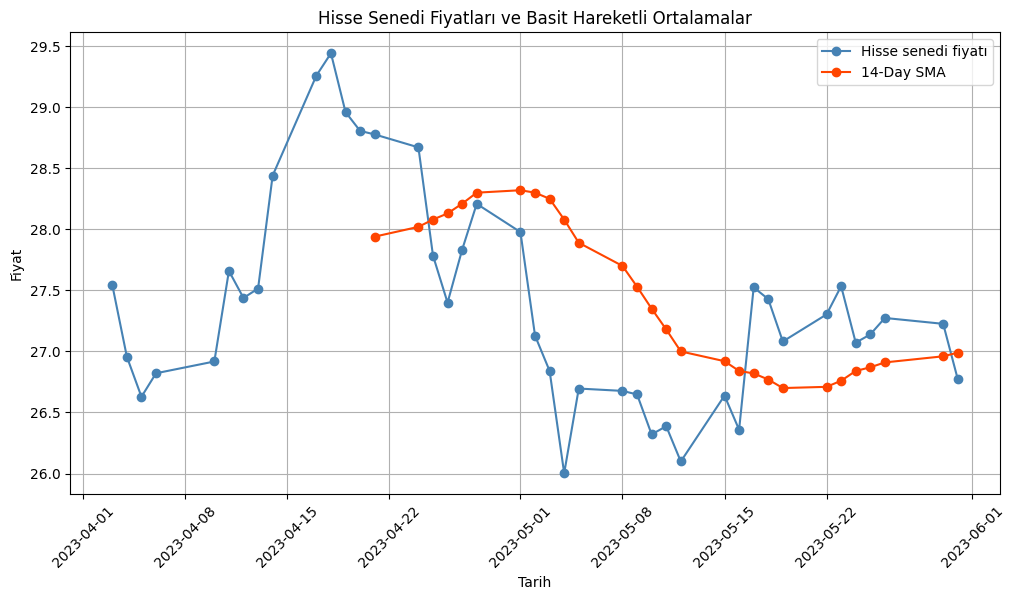

In [12]:
plot_data(stock_data.index, closing_prices, sma_values, window)

#### Yukarıdan bilgiler:

* Mavi çizgi, BAC'ın çeşitli zirve ve dip noktalarını gösteren hisse senedi fiyatını temsil eder ve belirli bir zaman dilimi içerisinde hisse senedinin değişken doğasını gösterir.
* Kırmızı çizgi BAC hisse senedi fiyatının 14 günlük SMA'sını temsil ediyor. Mavi çizgiyle karşılaştırıldığında daha az dalgalıdır (daha düzgündür), çünkü son 14 gündeki fiyatların ortalamasını alır ve bu da tek günlük fiyat hareketini azaltır. Bu SMA çizgisi, hisse senedi fiyatlarının yükselip yükselmediğini görmeyi kolaylaştırdığı için çok önemlidir. Hisse senedi fiyatları SMA çizgisini geçtiğinde, bu genellikle hisse senedinin bir yükseliş eğilimine girdiğini gösterir (bu, otomatik olarak bilgi vermek için otomatik temel eğilimler işlevinde uygulanır). 
* Her iki çizgi de genel bir düşüş eğilimi gösteriyor ve bu, Nisan ortasından Mayıs sonuna kadar açıkça görülüyor. hisse senedi fiyatı önemli ölçüde düştü ve SMA çizgisi de düştü; bu da BAC hissesi için düşüş eğilimine işaret ediyor. 
* Grafikte hisse senedi fiyatının SMA çizgisini geçtiği noktalar (Mayıs ortasından Mayıs sonuna kadar) var ve BAC için kısa vadeli bir ivme gösteriyor.

## Haber başlığının Duyarlılık Analizi

#### Analiz Yöntemi:

* GitHub deposunu kullanarak -> https://github.com/ranaroussi/yfinance/blob/main/yfinance/ticker.py -> haberleri almak için .get_news() yöntemini buldu
* HuggingPage Modelleri En Çok İndirilenler Sayfasını kullanarak, "duyarlılık" ve "duyarlılık"+"haberler" anahtar sözcüklerini verdi -> https://huggingface.co/models?pipeline_tag=text-classification&sort=downloads&search=sentiment -> bunu bir kısa listeye almak için kullandı Duygu analizi için önceden eğitilmiş çeşitli modeller: 
  1. mrm8488/distilroberta-finetuned-financial-news-sentiment-analytic -> Model, finansal haber verileri üzerine eğitildi.
  2. mrm8488/deberta-v3-ft-financial-news-sentiment-analiz -> Burada da finansal haber verileri üzerine eğitim verildi.
  3. ProsusAI/finbert -> Finansal metinlere özel.
  4. michelecafagna26/gpt2-medium-finetuned-sst2-duyarlılık -> GPT2 Tabanlı Genel Duyarlılık Modeli.
  5.cardiffnlp/twitter-roberta-base-sentiment-latest -> 124 milyon tweet konusunda eğitildi; bunlar potansiyel olarak finansal tweet'leri de içerebilir (Genel Duyarlılık Modeli).
  6. Jean-Baptiste/roberta-large-financial-news-sentiment-en -> Kanada finans haberleri üzerine eğitim aldı (BAC, Kanada'da popüler bir banka olduğundan).
* Analizi farklı modeller üzerinden yapmamın nedeni, her modelin farklı eğitim setine sahip olması ve sonuçların farklılık gösterebilmesidir. Bu nedenle, haber başlığının doğru duygusunu yakalamak için bu modelleri bir ardışık düzende uygulayacağım. duyarlılık analizi için bunu hisse senedi verilerimize uygulamak. Daha yorumlanabilir hale getirmek için, sonuçları tablo şeklinde bir forma koymak için burada ayrıca pandas veri çerçevesini kullandım.

_Not: Analiz için hem genel tabanlı modelleri hem de finansal spesifik tabanlı duyarlılık modellerini ekledim. Genel duyarlılık modellerini de seçmemin nedeni, genel eğitim veri modellerinin finansal haber duyarlılığını tahmin edip edemeyeceğini görmektir._

In [13]:
#Seçilmiş Modeller
models = {
    "distilroberta-finetuned-financial-news-sentiment": "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
    "deberta-v3-ft-financial-news": "mrm8488/deberta-v3-ft-financial-news-sentiment-analysis",
    "finbert": "ProsusAI/finbert",
    "gpt2-medium-finetuned-sst2-sentiment": "michelecafagna26/gpt2-medium-finetuned-sst2-sentiment",
    "twitter-roberta-base-sentiment-latest": "cardiffnlp/twitter-roberta-base-sentiment-latest",
    "roberta-large-financial-news-sentiment-en":"Jean-Baptiste/roberta-large-financial-news-sentiment-en"
}

#Her model için işlem hatları başlatılıyor
pipelines = {name: pipeline("sentiment-analysis", model=model) for name, model in models.items()}

#"BAC" - hisse senedi sembolü için haber verileri getiriliyor
ticker = "BAC"
stock = yf.Ticker(ticker)
news_articles = stock.get_news()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### get_news() işlevi tarafından döndürülen alan adlarının kontrol edilmesi:

In [14]:
if news_articles:
    first_article_keys = news_articles[0].keys()
    print(first_article_keys)
else:
    print("Hiçbir haber makalesi bulunamadı.")

dict_keys(['uuid', 'title', 'publisher', 'link', 'providerPublishTime', 'type', 'thumbnail', 'relatedTickers'])


_Yukarıdan, analizimize yardımcı olacak bir başlık ve sağlayıcıPublishTime -> olduğunu görebiliriz._

#### Haber başlıkları için Duyarlılık analizi yapılması:

In [15]:
#Tüm verileri tutacak bir liste
data = []

#Her makaleyi işliyoruz
for article in news_articles[:30]:  #30 haber başlığı sınırı tutuldu
    title = article['title']
    #'providerPublishTime'ı Unix zaman damgasından insan tarafından okunabilir tarihe dönüştürme
    date = pd.to_datetime(article['providerPublishTime'], unit='s').strftime('%Y-%m-%d %H:%M:%S')
    article_data = {"Title": title, "Date": date}
    
    #Her modeli kullanarak duygu analizi yapma
    for name, pipe in pipelines.items():
        try:
            sentiment = pipe(title)
            label = sentiment[0]['label']
            score = sentiment[0]['score']
            article_data[name] = f"{label}, {score:.2f}"
        except Exception as e:
            article_data[name] = "Error"

    #Makale_verilerini her başlığa, tarihe ve sonuçlara ekleme
    data.append(article_data)

#Sözlük listesini pandas DataFrame'e dönüştürme - daha iyi yorumlanabilirlik için
df = pd.DataFrame(data)
df.set_index(["Title"], inplace=True)

In [16]:
df

,Date,distilroberta-finetuned-financial-news-sentiment,deberta-v3-ft-financial-news,finbert,gpt2-medium-finetuned-sst2-sentiment,twitter-roberta-base-sentiment-latest,roberta-large-financial-news-sentiment-en
Title,,,,,,,
Bank of America Second Quarter 2024 Earnings: EPS Beats Expectations,2024-08-01 12:59:35,"positive, 1.00","positive, 0.98","positive, 0.90","POSITIVE, 1.00","positive, 0.62","positive, 0.94"
Bank of America Corp (BAC): A Strategic SWOT Insight,2024-08-01 05:04:25,"neutral, 1.00","neutral, 1.00","neutral, 0.92","POSITIVE, 1.00","neutral, 0.86","neutral, 0.95"
Analyst Report: Bank of America Corporation,2024-07-31 23:16:14,"neutral, 1.00","neutral, 1.00","neutral, 0.92","POSITIVE, 0.79","neutral, 0.80","neutral, 0.95"
UBS Sues Bank of America Unit for $200 Million Over Refusal to Cover Legal Costs,2024-07-31 19:45:35,"negative, 0.99","negative, 1.00","negative, 0.96","NEGATIVE, 1.00","negative, 0.67","negative, 0.94"
UBS sues Bank of America for $200 million over crisis-era mortgage costs,2024-07-31 14:42:43,"negative, 0.97","negative, 0.99","negative, 0.95","NEGATIVE, 1.00","neutral, 0.51","negative, 0.94"
JPMorgan Taps BofA’s Mukherjee for Equity Capital Markets,2024-07-31 14:35:49,"neutral, 1.00","neutral, 1.00","neutral, 0.80","NEGATIVE, 0.68","neutral, 0.91","neutral, 0.95"
Daily Spotlight: Bull Market Building Strength,2024-07-31 11:13:23,"positive, 1.00","neutral, 0.98","neutral, 0.79","POSITIVE, 0.99","positive, 0.74","positive, 0.94"
Is Bank of America Stock a Buy?,2024-07-31 11:10:00,"neutral, 0.63","positive, 0.66","neutral, 0.92","NEGATIVE, 0.96","neutral, 0.88","positive, 0.93"


#### Duygu Modeli Karşılaştırması:

* Modeller Arasındaki Fark: Aynı yeni başlıklar için her model (finansal tabanlı ve popüler genel modeller) arasındaki duyarlılık puanları önemli farklılıklar göstermektedir. Genel tweet tabanlı model (twitter-roberta-base-sentiment-latest), genel bir veri seti üzerinde eğitildiğinden beri, 5. başlıkta ("Bankaya Yatırım Yapmak...") görüldüğü gibi duyarlılık puanlarını hatalı bir şekilde tahmin ediyor gibi görünüyor ki bu gerçekten de bir hatadır. (burada kullanılan) tüm finansal haber tabanlı modeller tarafından doğru bir şekilde tahmin edilen olumlu duygu.

* Finansal Haberlere Özel Modeller: Distilroberta-finetuned-finansal-haber-duyarlılık-analizi, deberta-v3-ft-finansal-haber-duyarlılık-analizi, finbert ve roberta-large-financial-news-duyarlılık-en gibi modeller daha fazla performans gösterdi benim açımdan doğru. Bunun nedeni, eğitim verilerinin ya finansal metinlere ya da finansal haberlere özel olmasıdır. Bu modeller duyguyu daha iyi temsil ediyor. 

* Genel Duyarlılık Modelleri: gpt2-medium-finetuned-sst2-sentiment ve twitter-roberta-base-sentiment-latest gibi modeller finansal haberler için iyi bir seçim olmayabilir. Değerlendirmelerinin çoğu yanlıştı. Daha önce de belirtildiği gibi bu, bu modellerin haber başlıklarında iyi performans gösterip gösteremeyeceğini görmek için yapılan bir testti ancak burada, özellikle durum böyle görünmüyor.

Bu nedenle, genel tabanlı modelleri veri çerçevemizden kaldırmak:

In [17]:
df = df.drop(columns=['gpt2-medium-finetuned-sst2-sentiment', 'twitter-roberta-base-sentiment-latest'])

In [18]:
df

,Date,distilroberta-finetuned-financial-news-sentiment,deberta-v3-ft-financial-news,finbert,roberta-large-financial-news-sentiment-en
Title,,,,,
Bank of America Second Quarter 2024 Earnings: EPS Beats Expectations,2024-08-01 12:59:35,"positive, 1.00","positive, 0.98","positive, 0.90","positive, 0.94"
Bank of America Corp (BAC): A Strategic SWOT Insight,2024-08-01 05:04:25,"neutral, 1.00","neutral, 1.00","neutral, 0.92","neutral, 0.95"
Analyst Report: Bank of America Corporation,2024-07-31 23:16:14,"neutral, 1.00","neutral, 1.00","neutral, 0.92","neutral, 0.95"
UBS Sues Bank of America Unit for $200 Million Over Refusal to Cover Legal Costs,2024-07-31 19:45:35,"negative, 0.99","negative, 1.00","negative, 0.96","negative, 0.94"
UBS sues Bank of America for $200 million over crisis-era mortgage costs,2024-07-31 14:42:43,"negative, 0.97","negative, 0.99","negative, 0.95","negative, 0.94"
JPMorgan Taps BofA’s Mukherjee for Equity Capital Markets,2024-07-31 14:35:49,"neutral, 1.00","neutral, 1.00","neutral, 0.80","neutral, 0.95"
Daily Spotlight: Bull Market Building Strength,2024-07-31 11:13:23,"positive, 1.00","neutral, 0.98","neutral, 0.79","positive, 0.94"
Is Bank of America Stock a Buy?,2024-07-31 11:10:00,"neutral, 0.63","positive, 0.66","neutral, 0.92","positive, 0.93"


#### Her haber başlığına ilişkin duygu analizi bilgileri:

1. Schwab Yatırımcıları 5 Hisse Senedini Yığıyor ve 5 Hisseyi Daha Kurtarıyor: Duygular çoğunlukla nötr (3 modelin nötr tahminine göre), bu da durum hakkında dengeli bir görüşe işaret ediyor.
2. RBA, Faiz Oranını 12 Yılın En Yüksek Seviyesinde Tutuyor, Faiz Artışları için Daha Yüksek Çıtanın Sinyalini Veriyor: 2 modelden gelen olumlu ve tarafsız görüşler, her biri duruma ilişkin dengeli/iyimser bir görüş öneriyor.
3. Ticari Gayrimenkul 'Yönetilebilir' Bir Sorun Ancak Bazı Bankalar Kapanacak: Bu başlık sürekli olarak olumsuz bir tepki aldı. Başlıkta bazı bankaların kapandığından bahsedildiğinden olumsuz hava mantıklı geliyor.
4. Morgan Stanley, Bu 2 Bankacılık Hissesi Devinin 'Geleceği Parlak' Diyor: Tüm modellerden gelen olumlu duygular, bu bankacılık hisselerinin gelecekteki performansına güven göstererek duruma iyimser bir bakış açısı kazandırıyor ve aynı zamanda büyük bir saygınlık tarafından da destekleniyor. firma.
5. Beş yıl önce Bank of America'ya (NYSE:BAC) yatırım yapmak size %33'lük bir kazanç sağlardı: Tüm modellerin olumlu yaklaşımı, Bank of America'nın başarısını ve büyümesini gösteriyor.
6. Resmen Boğa Piyasasındayız. İşte Şimdi Aldığım 2 Hisse Senedi: Bunun şirketten ziyade piyasayla ilgili olduğunu öne süren 3 tarafsız duygu.
7. Bank of America, CEO Brian Moynihan'ın Maaş Paketini 29 Milyon Dolara Çekti: Başlığın CEO'nun maaş paketiyle ilgili bir eleştiri gibi göründüğü modellerden çoğunlukla olumsuz görüşler.
8. Citigroup Zengin Müşterilerin Gerisinde Kaldı. Onları Geri Kazanabilir mi?: Karışık duygular ama finansal açıdan olumsuzluk hakim, ki bu da mantıklı.

#### Tarih ve Duygu Analizi:

In [19]:
#Duygu dizisini puana dönüştürme işlevi
def convert_sentiment_to_score(sentiment_str):
    sentiment, score = sentiment_str.split(", ")
    score = float(score)
    if sentiment == "positive":
        return score
    elif sentiment == "negative":
        return -score
    return 0    #Nötr duygu puanını 0'da tutmak

#Duygu dizilerini her model için puanlara dönüştürme
for column in df.columns[1:]:
    df[column] = df[column].apply(convert_sentiment_to_score)

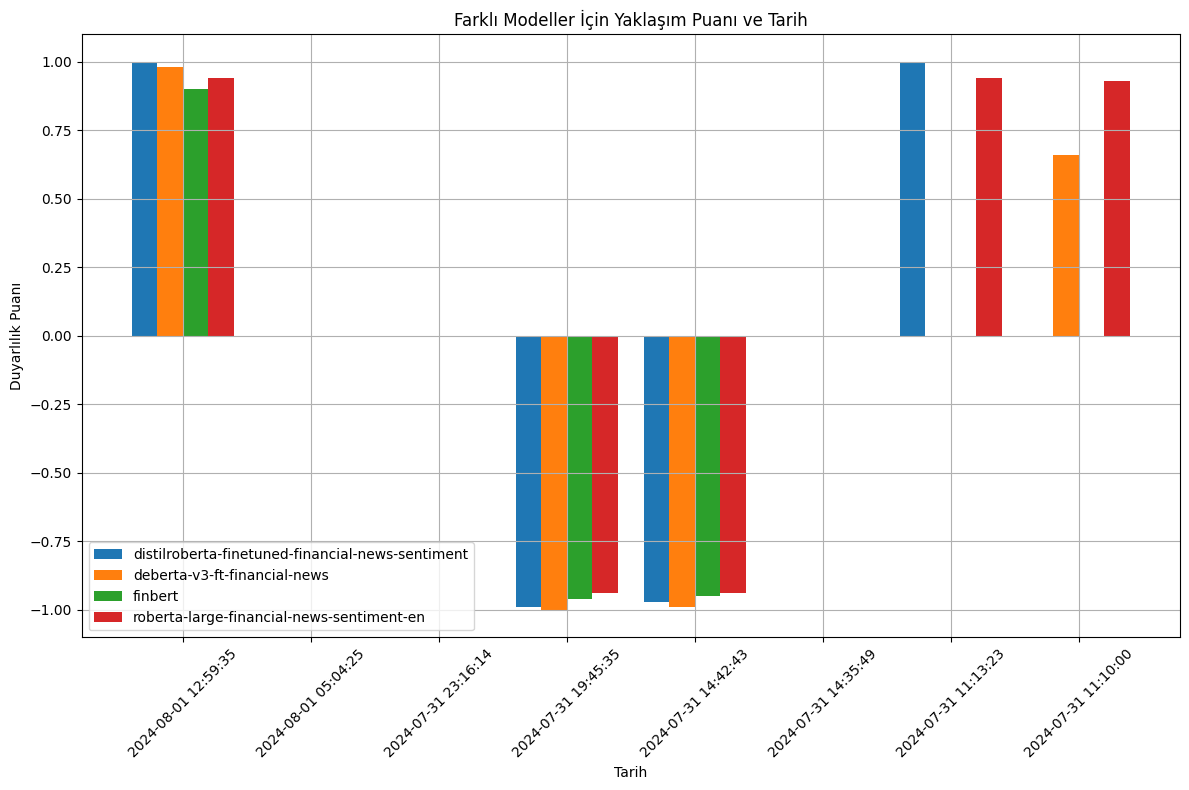

In [20]:
#Plotting
plt.figure(figsize=(12, 8))

n_models = len(df.columns) - 1  
bar_width = 0.8 / n_models  
dates = np.arange(len(df['Date']))  

for i, column in enumerate(df.columns[1:], start=1):
    offsets = (i - (n_models + 1) / 2) * bar_width
    plt.bar(dates + offsets, df[column], width=bar_width, label=column)

plt.title('Farklı Modeller İçin Yaklaşım Puanı ve Tarih')
plt.xlabel('Tarih')
plt.ylabel('Duyarlılık Puanı')
plt.legend()
plt.grid(True)
plt.xticks(dates, df['Date'], rotation=45)  
plt.tight_layout()
plt.show()

#### Yukarıdan bilgiler:

Yukarıdaki grafikten olumlu duyguları not edersek, bu tarih/saatlerde hisse senedi fiyatlarının artmasıyla ilgili olabilir.
Her üç modelin de olumlu bir görüş üzerinde mutabakata vardığı tarihler, o tarihte BAC için gerçekten iyi haberlerin olduğu anlamına gelir. Yalnızca bir veya iki modelin olumlu görüş gösterdiği tarihler, haberlerin daha az oranda iyi olduğunu veya modellerin haberleri farklı yorumladığını gösterebilir. En yüksek çubuklara sahip tarihler (1'e yakın) çok olumlu haberlere işaret ediyor.

#### Duygular olumluyken BAC'ın yükseliş eğilimi gösterip göstermediğini kontrol etme (esas olarak 5 Şubat ile 7 Şubat arasındaki zaman dilimini inceleyerek):

In [21]:
ticker = "BAC"
start_date = "2024-02-01"
end_date = "2024-02-08"
window = 3

stock_data = get_stock_data(ticker, start_date, end_date)
closing_prices = stock_data['Close'].tolist()
sma_values = calc_simple_moving_average(closing_prices, window)

print_data_and_insights(stock_data.index, closing_prices, sma_values)

Date            Price      SMA       
2024-02-05      32.56      32.90     
2024-02-06      32.61      32.74     
2024-02-07      32.75      32.64     

Temel Analizler:
Hisse senedi Son fiyat SMA'nın üzerinde olduğundan yükseliş eğilimi var.
Fiyat, önceki güne göre %0.42 oranında increased yönünde.
Şu anda son zamanların en yüksek seviyesinde. gösteriyor



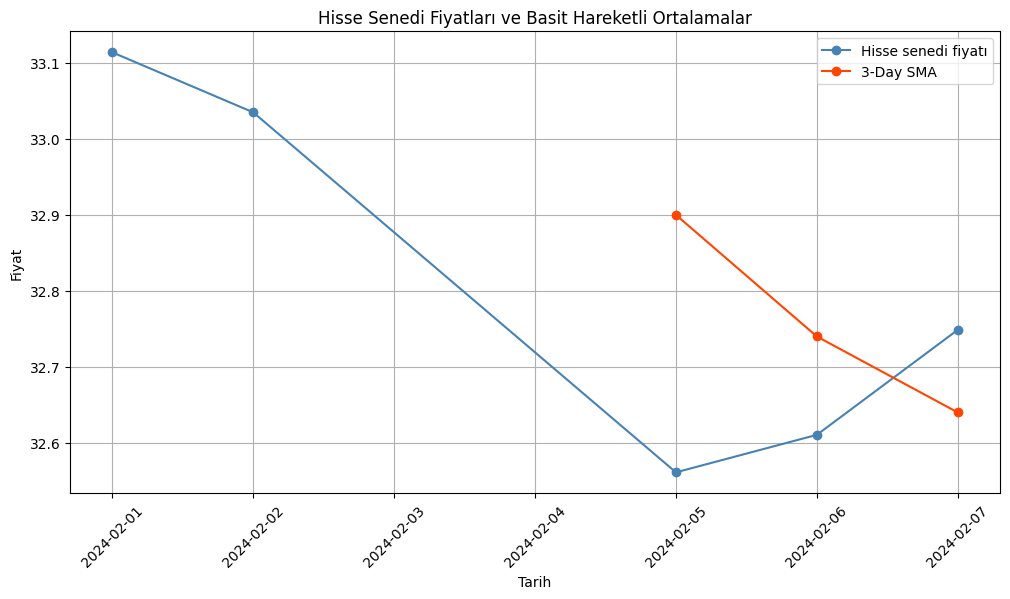

In [22]:
plot_data(stock_data.index, closing_prices, sma_values, window)

#### Yukarıdan bilgiler: 

Yukarıdaki grafikten ve otomatikleştirilmiş temel bilgilerden, 5 Şubat 2024'ten 7 Şubat 2024'e kadar bir yükseliş eğilimi olduğunu görebiliriz, çünkü önceki grafikte pek çok olumlu düşünce vardı ve özellikle 7'nci haberle birlikte hisse senedi fiyatının şu şekilde olduğunu görebiliriz: Yukarıdaki grafikte 7. sırada SMA'nın üzerinde. Dolayısıyla hisse fiyatını artıran olumlu duyguların olduğu yönündeki analizimiz doğrudur.